# **AP157 Image Processing Lab Assignment**
### Module B2: Fourier Transform Applications in Image Processing

_Instructions_: Answer each part of the assignment as completely as you can. Discuss **all** your code and results as clearly and concisely as possible.

_Scoring Criteria_: 50% - *correctness of code*; 50% - *discussion of the code and results*. Maximum score is **100 points** (Parts 1 and 2 are worth 20 and 80 points, respectively).

_Credits_: This lab assignment is based on the AP157 modules of Dr. Maricor Soriano and scripts created by Mr. Rene Principe

### Student Information

_Full Name (Last Name, First Name)_: Daffon, David D.\
_Student No._: 2021-04594\
_Section_: THY-TX-1

### Submission Information

_Date and Time Submitted (most recent upload)_:

**HONOR PLEDGE** I affirm that I have upheld the highest principles of honesty and integrity in my academic work and that this lab assignment is my own work.

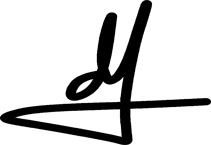

In [59]:
from IPython.display import Image #run cell to display e-sig
Image(filename="sig.png")

**DAVID D. DAFFON**

### Grading Information (c/o Instructor)

TOTAL SCORE: **[]**/100

Score breakdown:
* Part 1 - []/30
* Part 2 - []/20
* Part 3 - []/20
* Part 4 - []/30

_Date and Time Scored (MM/DD/YYYY HH:MM AM/PM):_

In [60]:
# import libraries
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.patches import Polygon
from mpl_toolkits.axes_grid1 import make_axes_locatable
from tqdm import tqdm

from numpy.fft import fft2,ifft2,fftshift,ifftshift
import random

import cv2

from skimage import color, data, exposure
from skimage.transform import rescale
import skimage as ski

#### PART 1 - Apply 2D FFT on simple apertures *(30 points)*

1. [15 pts.] Rectangular apertures with (width, height):
- (50, 20) pixels
- (20, 50) pixels
2. [15 pts.] Circular apertures with radii:
- 5 pixels
- 10 pixels
- 20 pixels

For each aperture type, perform the following steps:

- **Step 1: Define Input Aperture**
  - Generate a 2D array representing a rectangle/circle with the specified size within a square grid of size 128 pixels (representing an optical system, for example).
  
- **Step 2: Compute Fourier Transform**
  - Use the Fast Fourier Transform (FFT) algorithm to compute the Fourier transform of the input aperture.

- **Step 3: Shift the FFT**
  - Shift the zero frequency component of the Fourier transform to the center.

- **Step 4: Visualization (Plotting)**
  - Plot the original aperture.
  - Plot the magnitude of the shifted Fourier transform.
  - Plot the log-scaled magnitude of the shifted Fourier transform.
  - Add colorbars to the plots for reference.

- **Step 5: Display**
  - Display the plots in a single figure with three subplots (original aperture, FFT magnitude, log-scaled FFT magnitude).



##### Author's note

In the first code cell succeeding this, I define the functions for creating the rectangular and circular apertures.

In [61]:
def rect_apt(l, h, dim, xs, ys): # length, height, dimensions, x shift (offset term, leaving as zero centers the aperture), y shift
  m, n = dim, dim # dim[0], dim[1] for non-square dimensions

  xx = np.linspace(-0.5*m, 0.5*m, m) # Creating meshgrid.
  yy = np.linspace(-0.5*n, 0.5*n, n)
  X, Y = np.meshgrid(xx, yy)

  r_apt = np.zeros_like(X, dtype=float) # Creating an array of zeros of equal dimension to meshgrid.
  r_apt[np.where(((-0.5*l+xs) < X) & (X < (0.5*l+xs)) & ((-0.5*h+ys) < Y) & (Y < (0.5*h+ys)))] = 1.0 # Filling in ones where the rectangle 
  # is traced by the boundary conditions.

  return r_apt # Output


def circ_apt(rad, dim, xt, yt): # radius, dimensions, x shift, y shift
  m, n = dim, dim # dim[0], dim[1] for non-square dimensions.

  xx = np.linspace(-0.5*m, 0.5*m, m) # Creating meshgrid and circle function.
  yy = np.linspace(-0.5*n, 0.5*n, n)
  X, Y = np.meshgrid(xx, yy)
  R = np.sqrt((X+xt)**2 + (Y+yt)**2)
  
  c_apt = np.zeros_like(R, dtype=float) # Creating an array of zeros of equal dimension to meshgrid.
  c_apt[np.where(R < rad)] = 1.0 # Filling in ones where the circle is traced by the boundary condition.

  return c_apt # Output

Then, I create the following code cell to test if my functions work.

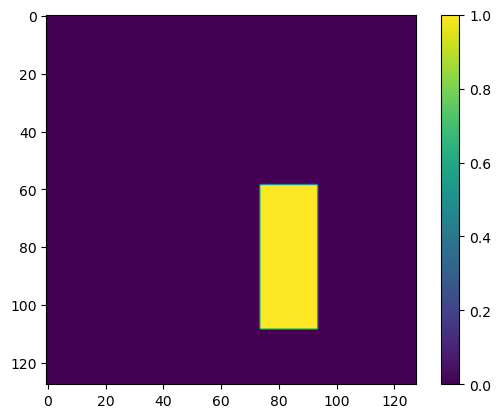

In [62]:
r0 = rect_apt(50, 20, 128, 0, 0) # Test
r00 = rect_apt(20, 50, 128, 20, 20)
c0 = circ_apt(30, 128, 0, 0)
c00 = circ_apt(5, 128, 30, 30)

plt.imshow(r00) # Testing for r0, r00, c0, c00
plt.colorbar()

Which they seem to do. So now, I create another function for implementing steps 2 and 3:

In [63]:
def ffter(apt):
    fapt = fftshift(np.abs(fft2(apt))) # Taking the shifted fft of the 2D fft of the input aperture.

    return fapt # Output

With these functions now defined, I implement them to create the required apertures with some extra. I added offset to the extra ones to see what the effect will be.

In [64]:
r1 = rect_apt(50, 20, 128, 0, 0)
fr1 = ffter(r1)

r2 = rect_apt(20, 50, 128, 0, 0)
fr2 = ffter(r2)

r3 = rect_apt(30, 30, 128, 20, 20)
fr3 = ffter(r3)

c1 = circ_apt(5, 128, 0, 0)
fc1 = ffter(c1)

c2 = circ_apt(10, 128, 0, 0)
fc2 = ffter(c2)

c3 = circ_apt(20, 128, 0, 0)
fc3 = ffter(c3)

c4 = circ_apt(20, 128, 30, 30)
fc4 = ffter(c4)

Now, I define a function for plotting these apertures, their ffts, and their logscale ffts.

In [65]:
def plotter(apt, fapt, title):

    cmap = "plasma"

    plt.figure(figsize=(8, 4), dpi = 150) # Preliminary for creating subplots
    plt.suptitle(title + " aperture")

    plt.subplot(131) # Plotting the aperture itself
    plt.imshow(apt, cmap = cmap)
    plt.title("Aperture")
    plt.colorbar(shrink=0.8)

    plt.subplot(132) # Plotting the fft
    plt.imshow(fapt, cmap = cmap)
    plt.title("FFT")
    plt.colorbar(shrink=0.8)

    plt.subplot(133) # Plotting the logscale fft
    plt.imshow(np.log(fapt), cmap = cmap)
    plt.title("logscale FFT")
    plt.colorbar(shrink=0.8)

    plt.subplots_adjust(wspace=0.6)

I implement this function over the apertures to display all the necessary plots.

C:\Users\David\AppData\Local\Temp\ipykernel_6024\423095994.py:19: RuntimeWarning: divide by zero encountered in log
  plt.imshow(np.log(fapt), cmap = cmap)


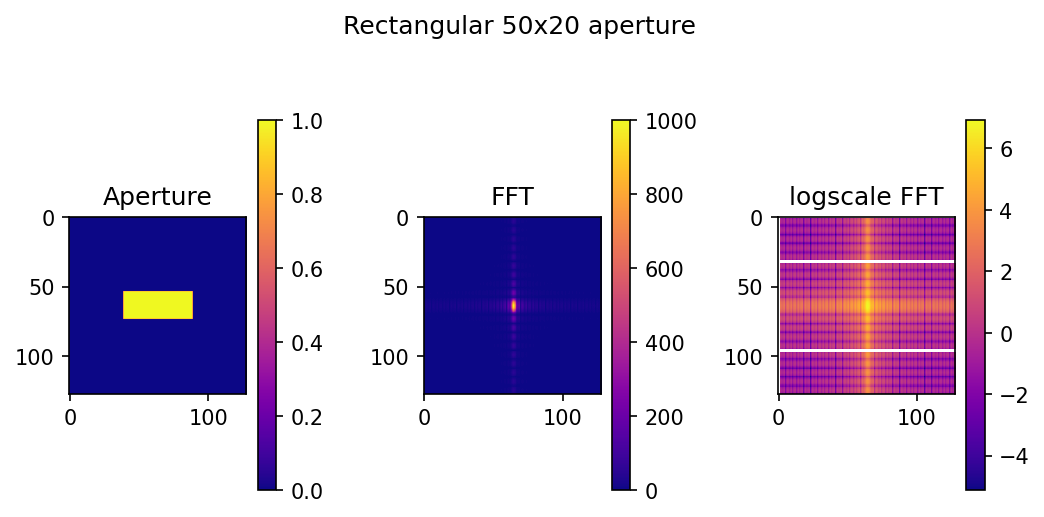

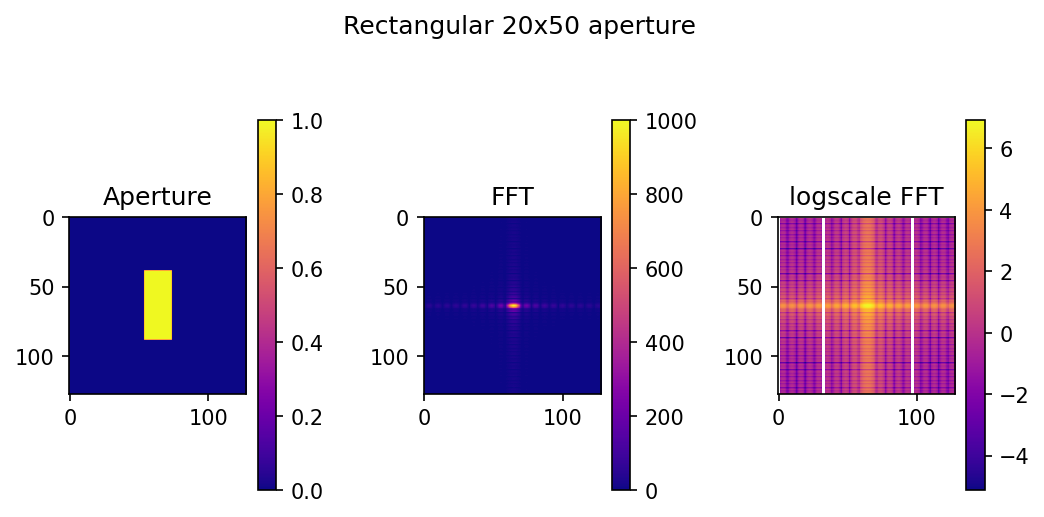

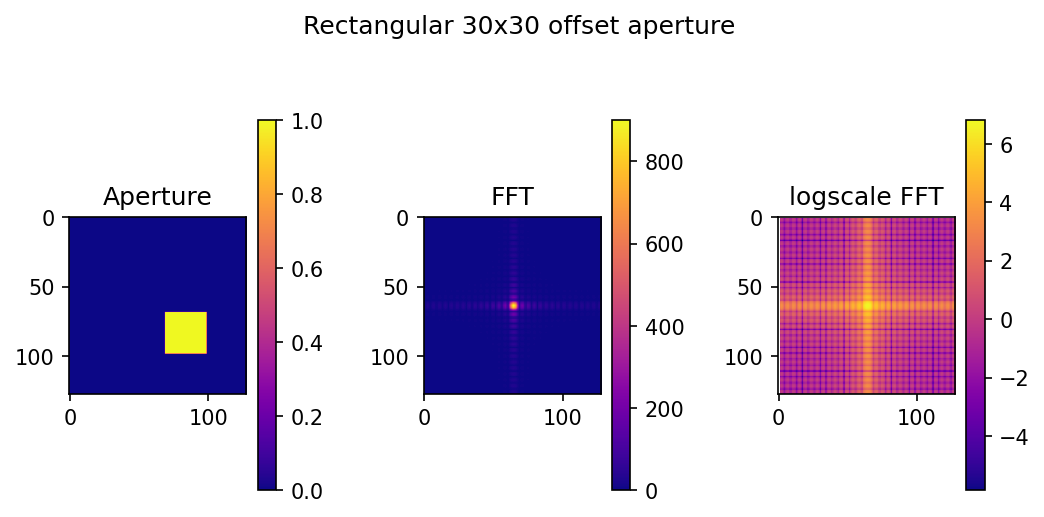

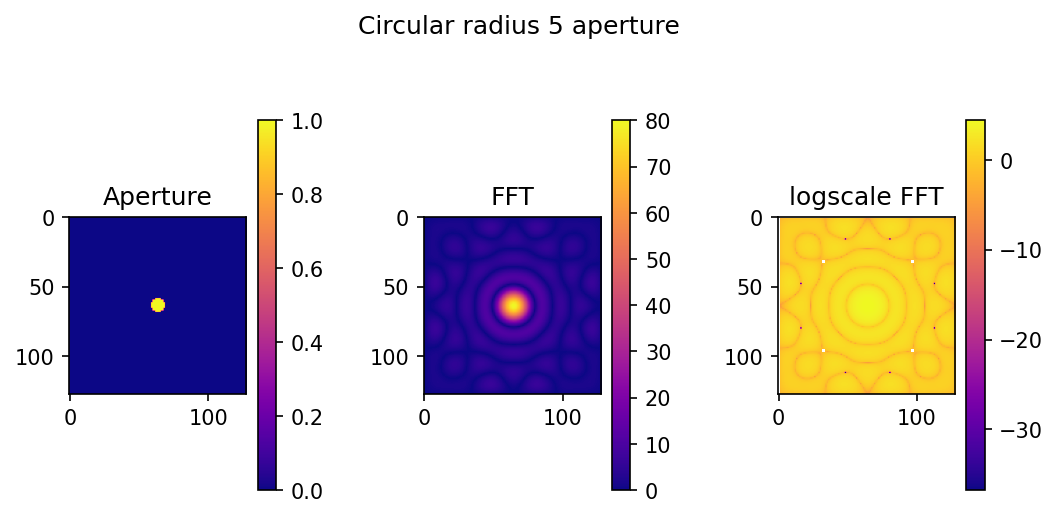

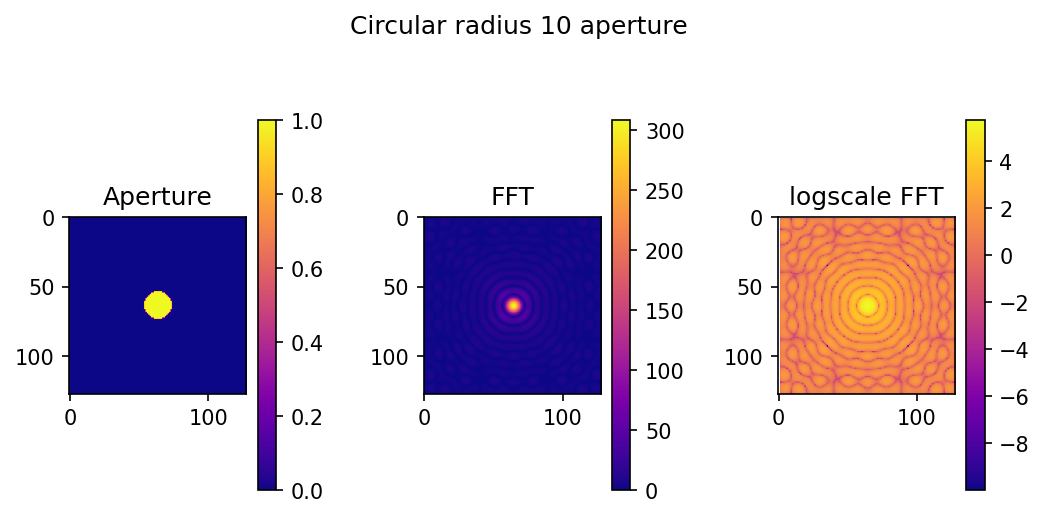

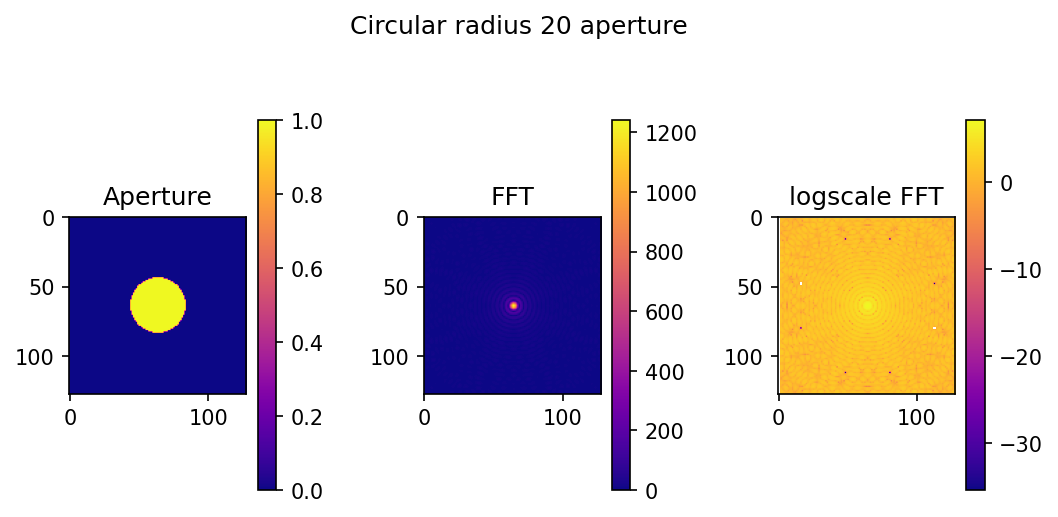

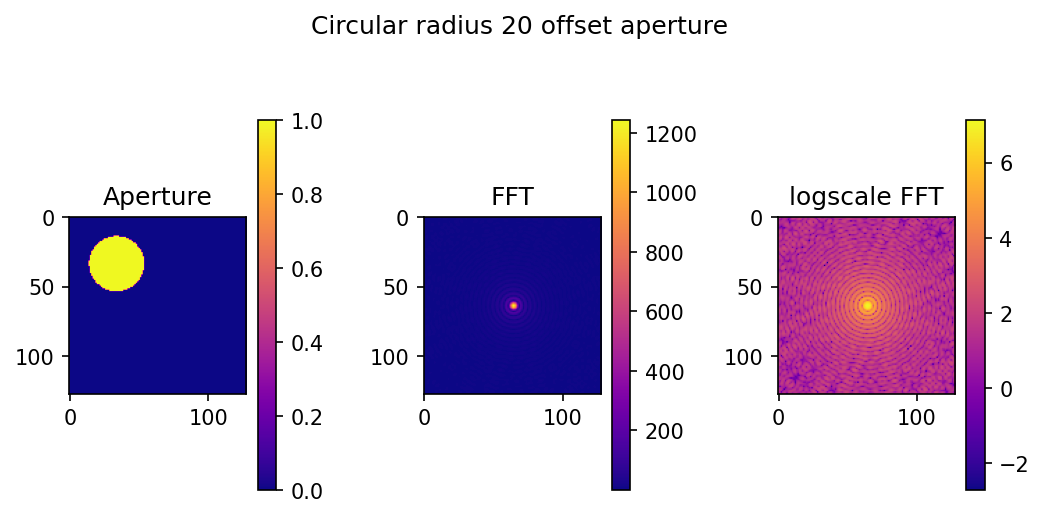

In [66]:
plotter(r1, fr1, "Rectangular 50x20")
plotter(r2, fr2, "Rectangular 20x50")
plotter(r3, fr3, "Rectangular 30x30 offset")

plotter(c1, fc1, "Circular radius 5")
plotter(c2, fc2, "Circular radius 10")
plotter(c3, fc3, "Circular radius 20")
plotter(c4, fc4, "Circular radius 20 offset")

It seems that the offsetting did not do much to change the FFT and logscale FFT plots. This may be due to the usage of fftshift.

#### PART 2 - Convolution *(20 points)*

Now that we've shown that FT acts as if an imaging system, suppose we have an image and convolve it with a circular aperture with different radii. Assuming that the circular aperture is a camera lens, we want to show how the reconstruction of the original image can be limited by the properties of the camera lens (or any imaging device) such as aperture size.

Take the astronaut image from skimage and convolve it with circular apertures of radii: 8, 32, and 64 pixels.

To do this, you can perform the ff. steps:

- **Compute Fourier Transform of Image:**
  - Use `fft2` to compute the 2D Fourier Transform of the input image.
  
- **Compute Fourier Transform of Aperture:**
  - Use `fftshift` to shift the zero-frequency component to the center.

- **Perform Element-wise Multiplication in Frequency Domain:**
  - Multiply the Fourier Transform of the image and the shifted aperture element-wise in the frequency domain.

- **Compute Inverse Fourier Transform:**
  - Use `ifft2` to compute the 2D Inverse Fourier Transform of the product from the previous step.

- **Visualization (Plotting):**
  - Create a figure with three subplots to visualize the original image, the aperture, and the convolution result.

For this part, I recycle my trusty <code>circ_apt</code> function. I create three apertures that I want to use.

In [67]:
a1 = circ_apt(20, 512, 0, 0) 
a2 = circ_apt(5, 512, 0, 0)
a3 = circ_apt(10, 512, 50, 50) # Offset aperture!

I then create the convolver function to perform parts 2 to 4.

In [90]:
def convolver(img, apt):
    c_img = np.abs(ifftshift(ifft2(fft2(img)*fft2(apt)))) # Performing the 2D ffts, multiplying, inversing, and shifting.

    return c_img # Output

I load the astronaut image and then implement the convolver function on it.

In [92]:
img = ski.color.rgb2gray(data.astronaut())*256

cv1 = convolver(img, a1) # Implementing convolver.
cv2 = convolver(img, a2)
cv3 = convolver(img, a3)

For plotting, we can add some revisions to <code>plotter</code>. I name this new function <code>plotter2</code>.

In [98]:
def plotter2(img, c_img, apt, title):

    cmap = "BuPu_r"

    plt.figure(figsize=(10, 4), dpi = 150) # Preliminary for creating subplots.
    plt.suptitle("Astronaut convolution with " + title + " aperture")

    plt.subplot(131) # Plotting the original image itself.
    plt.imshow(img, cmap = cmap)
    plt.title("Original Image")

    plt.subplot(132) # Plotting the aperture.
    plt.imshow(apt, cmap = cmap)
    plt.title(title + " aperture")

    plt.subplot(133) # Plotting the resulting convolved image.
    plt.imshow(c_img, cmap = cmap)
    plt.title("Convolved Image")

    plt.subplots_adjust(wspace=0.6)

I the use this new function to visualize our original image, aperture, and the resulting convolved image.

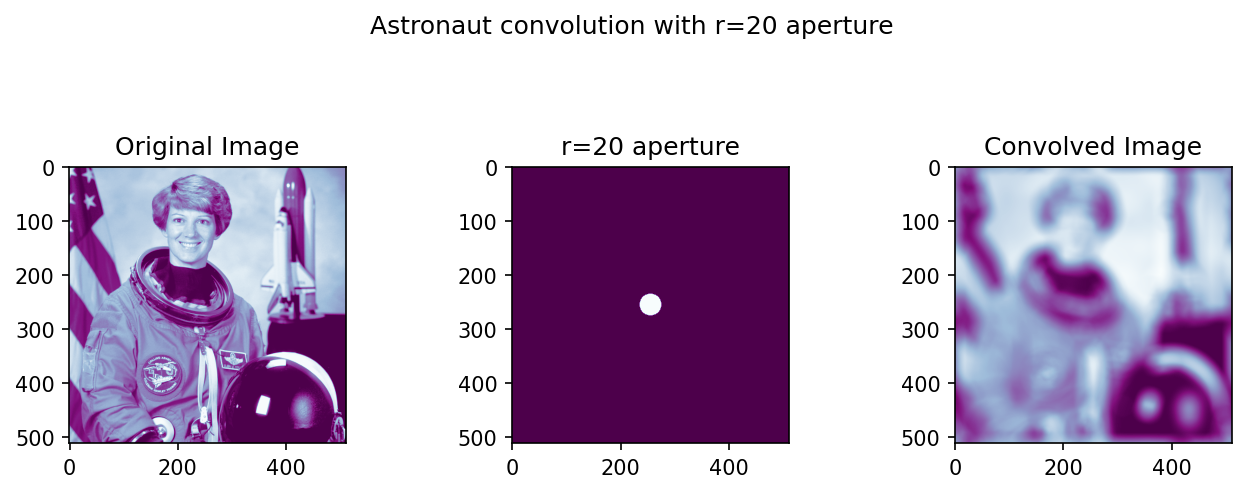

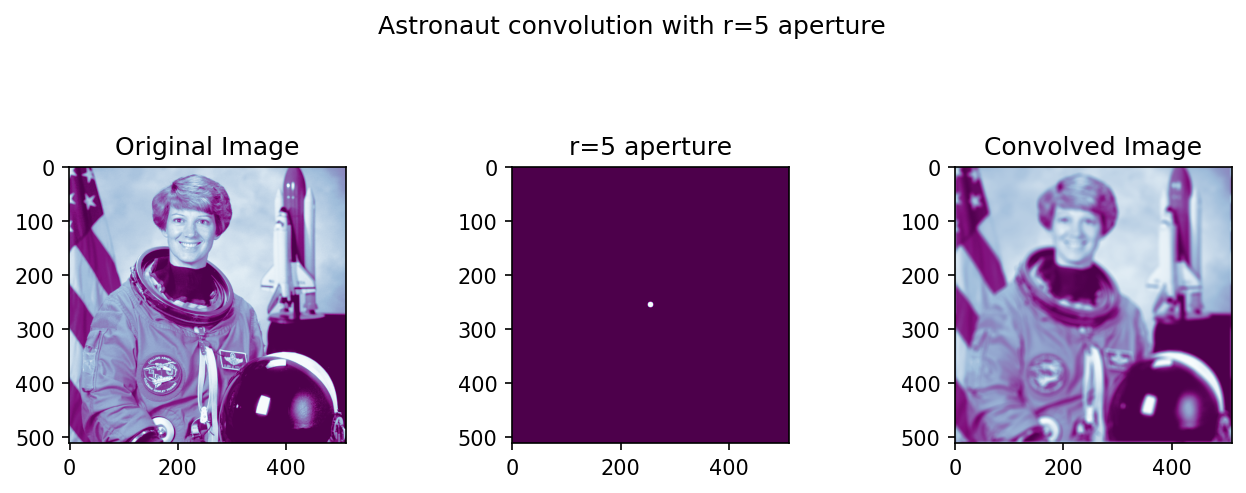

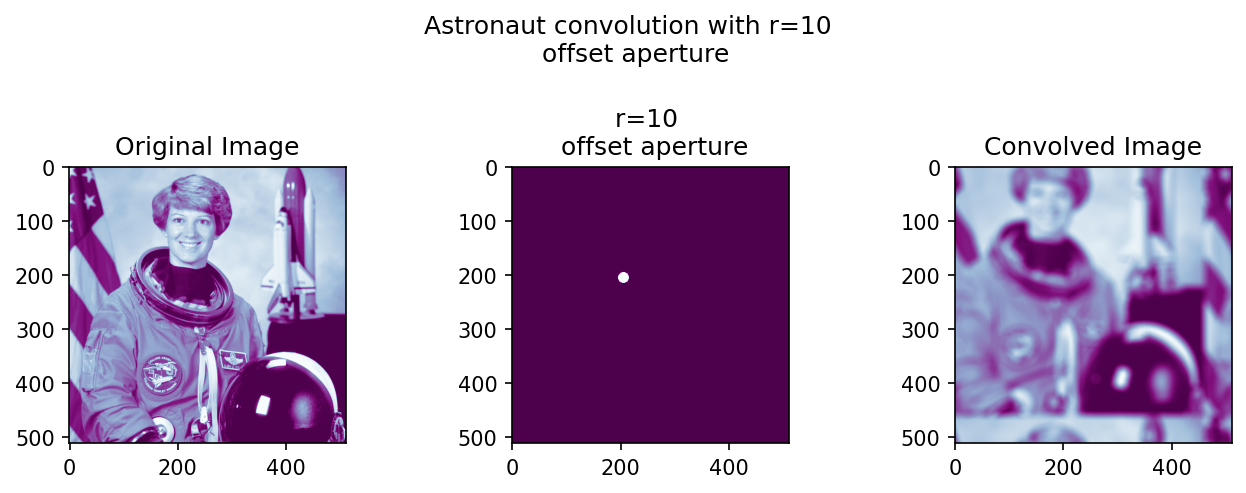

In [97]:
plotter2(img, cv1, a1, "r=20")
plotter2(img, cv2, a2, "r=5")
plotter2(img, cv3, a3, "r=10 \n offset")

We see that an offset aperture actually also offsets the convolved image. Also, as expected the larger aperture returns a blurrier convolved image than the smaller aperture.

#### PART 3 - Correlation *(20 points)*

In this task, we observe using the correlation method that the similarity between two functions can be extracted-- this is also referred to as template matching.

You can get the test and target images from the "Datasets" folder in the course GDrive:
- AP157_moduleB2_correlation_test_image.png (with text "The Rain in Spain Stays Mainly in the Plain")
- AP157_moduleB2_correlation_target_image.png (with text "A")

In the correlation result, the high intensity portions indicate the presence of letter 'A' on the test image.

To get the correlation, you can perform the ff. steps:

- **Compute Fourier Transforms:**
  - Use `fft2` to compute the 2D Fourier Transform of the input test image (`image`).
  - Use `fft2` and `np.conj` to compute the complex conjugate of the 2D Fourier Transform of the target template.

- **Compute Cross-Correlation in Frequency Domain:**
  - Multiply the Fourier Transforms of the image and the complex conjugate of the Fourier Transform of the target template element-wise in the frequency domain.

- **Compute Inverse Fourier Transform:**
  - Use `ifft2` to compute the 2D Inverse Fourier Transform of the correlation.

- **Visualization (Plotting):**
  - Create a figure with three subplots to visualize the original image, the target image, and the correlation result.
  - Add colorbars to each subplot for reference and to visualize intensity levels.

#### PART 4 - Application: Canvas Weave Modeling and Removal *(30 points)*

Suppose we want to investigate the brush strokes of a painter. However, the texture of the canvas obscures our view of the brushstrokes. Let’s use FFT to remove the canvas weave.

Perform the ff. steps:

1. Open the image AP157_moduleB_canvas_weave_image.jpg (also in the Datasets folder; the image is from a painting by Dr. Vincent Daria.) and convert into a grayscale image. To enhance the detection of repeating patterns we first subtract the mean grayscale from the image. This will remove the DC bias of intensity images.

2. Take the FT of the mean-subtracted image and take note of the symmetric peaks. These are the sinusoids that make up the canvas weave image, similar to the rotation property of sinusoids we did earlier.

3. Manually create a filter mask in the FT space to remove the canvas weave patterns. This is a matrix which is the same size as the image. The filter is all 1’s but are zero at the locations of the sinusoidal peaks. FFT shift this filter and multiply this to the complex FT of the Red, Green and Blue channels of the original image (not mean subtracted). The filter essentially “erases” the peaks. Take the inverse FT of the filtered FT and overlay the filtered R,G,B images. Did the canvas weave vanish enough that the paint and brushstrokes remain?

4. Invert the filter mask (0's become 1's and vice versa) and take the inverse Fourier transform. Observe the generated modulus image. Is it close to the appearance of the canvas weave?

In [ ]:
pt0 = ski.io.imread("b3_imgs/part4.jpg", as_gray=False)
pt = ski.io.imread("b3_imgs/part4.jpg", as_gray=True) # To dim the image a bit.

pt2 = fft2(cv2.subtract(pt, np.mean(pt)))


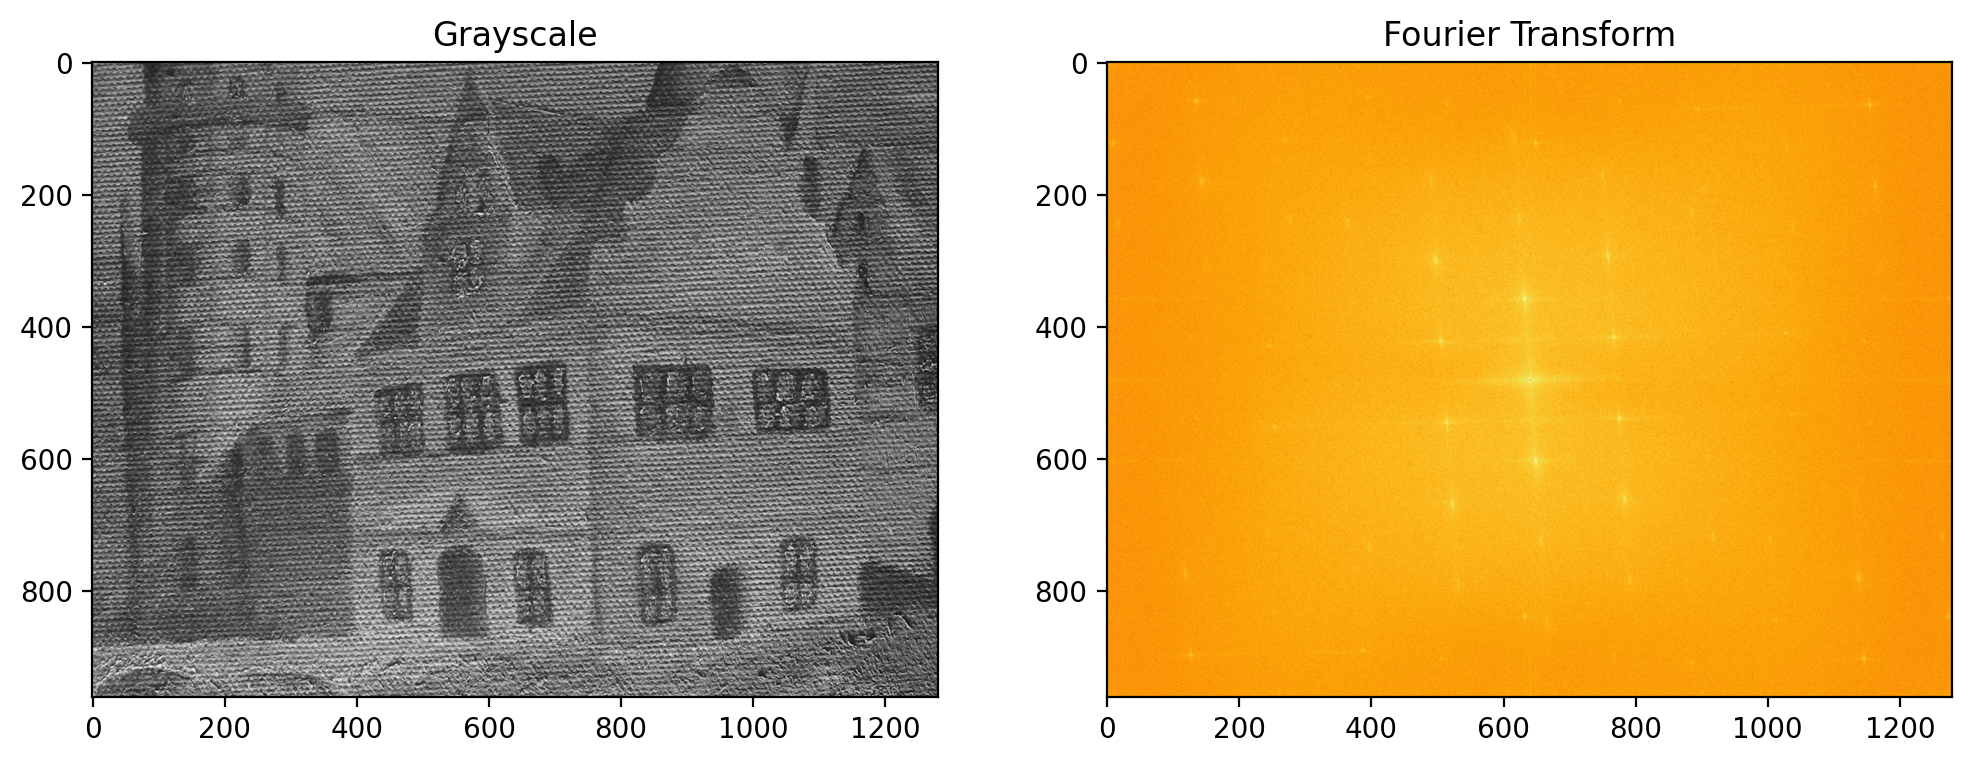

In [ ]:
plt.figure(figsize=[12, 6], dpi=200)

plt.subplot(1, 2, 1)
plt.imshow(pt, cmap='gray')
plt.title('Grayscale')

plt.subplot(1, 2, 2)
plt.imshow(fftshift(np.log(np.abs(pt2))), cmap='inferno')  
plt.title('Fourier Transform')

plt.show()

In [ ]:
def holer(rr, l, h, xt, yt):
  xx = np.linspace(-0.5*l, 0.5*l, l)
  yy = np.linspace(-0.5*h, 0.5*h, h)
  X, Y = np.meshgrid(xx, yy)
  circ = np.sqrt((X+xt)**2 + (Y+yt)**2)
  hole = np.zeros(np.shape(circ))
  hole[np.where(circ < rr)] = 1.0
  return hole

def shifter(og, mk):
  R, G, B = cv2.split(np.array(og))
  R_ct = np.abs(ifft2(fftshift(fft2(R))*mk))
  G_ct = np.abs(ifft2(fftshift(fft2(G))*mk))
  B_ct = np.abs(ifft2(fftshift(fft2(B))*mk))

  ft = np.dstack((R_ct, G_ct, B_ct))
  ft = ft/np.max(ft)

  return ft

In [ ]:
mask = cv2.inRange((fftshift(np.abs(np.log(pt2)))), 0, 6.8)/255
mask[np.where(holer(30, 1280, 960, 0, 0) > 0)] = 1
mask[np.where(holer(20, 1280, 960, 20, 0) > 0)] = 1
mask[np.where(holer(20, 1280, 960, -20, 0) > 0)] = 1
mask[np.where(holer(20, 1280, 960, 40, 0) > 0)] = 1
mask[np.where(holer(20, 1280, 960, -40, 0) > 0)] = 1
mask[np.where(holer(20, 1280, 960, 0, 20) > 0)] = 1
mask[np.where(holer(20, 1280, 960, 0, -20) > 0)] = 1
mask[np.where(holer(20, 1280, 960, 0, 30) > 0)] = 1
mask[np.where(holer(20, 1280, 960, 0, -30) > 0)] = 1
mask[np.where(holer(15, 1280, 960, 50, 0) > 0)] = 1
mask[np.where(holer(15, 1280, 960, -50, 0) > 0)] = 1

In [ ]:
pt_f = shifter(pt0, mask)

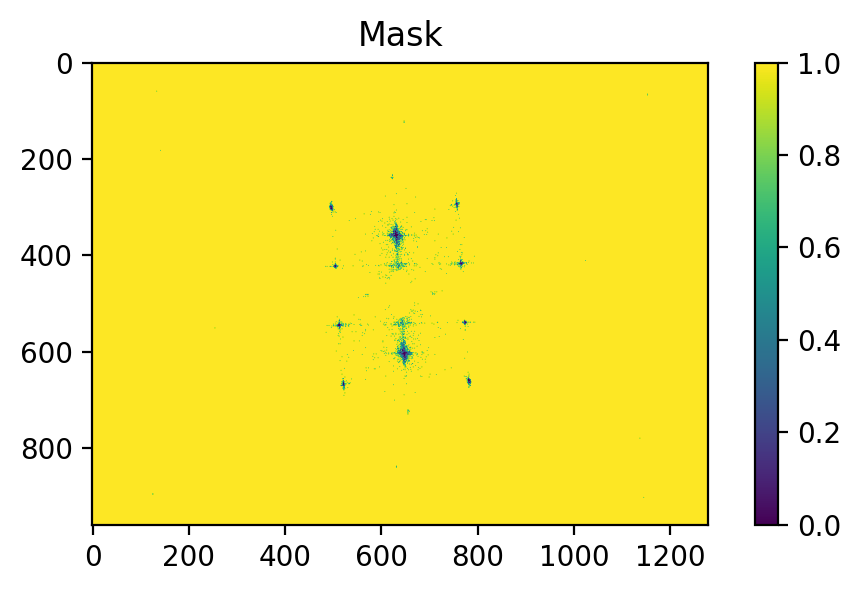

In [ ]:
plt.figure(figsize=[6, 3], dpi=200)

plt.subplot(111)
plt.imshow(mask)
plt.title('Mask')
plt.colorbar()

Text(0.5, 1.0, 'Filtered')

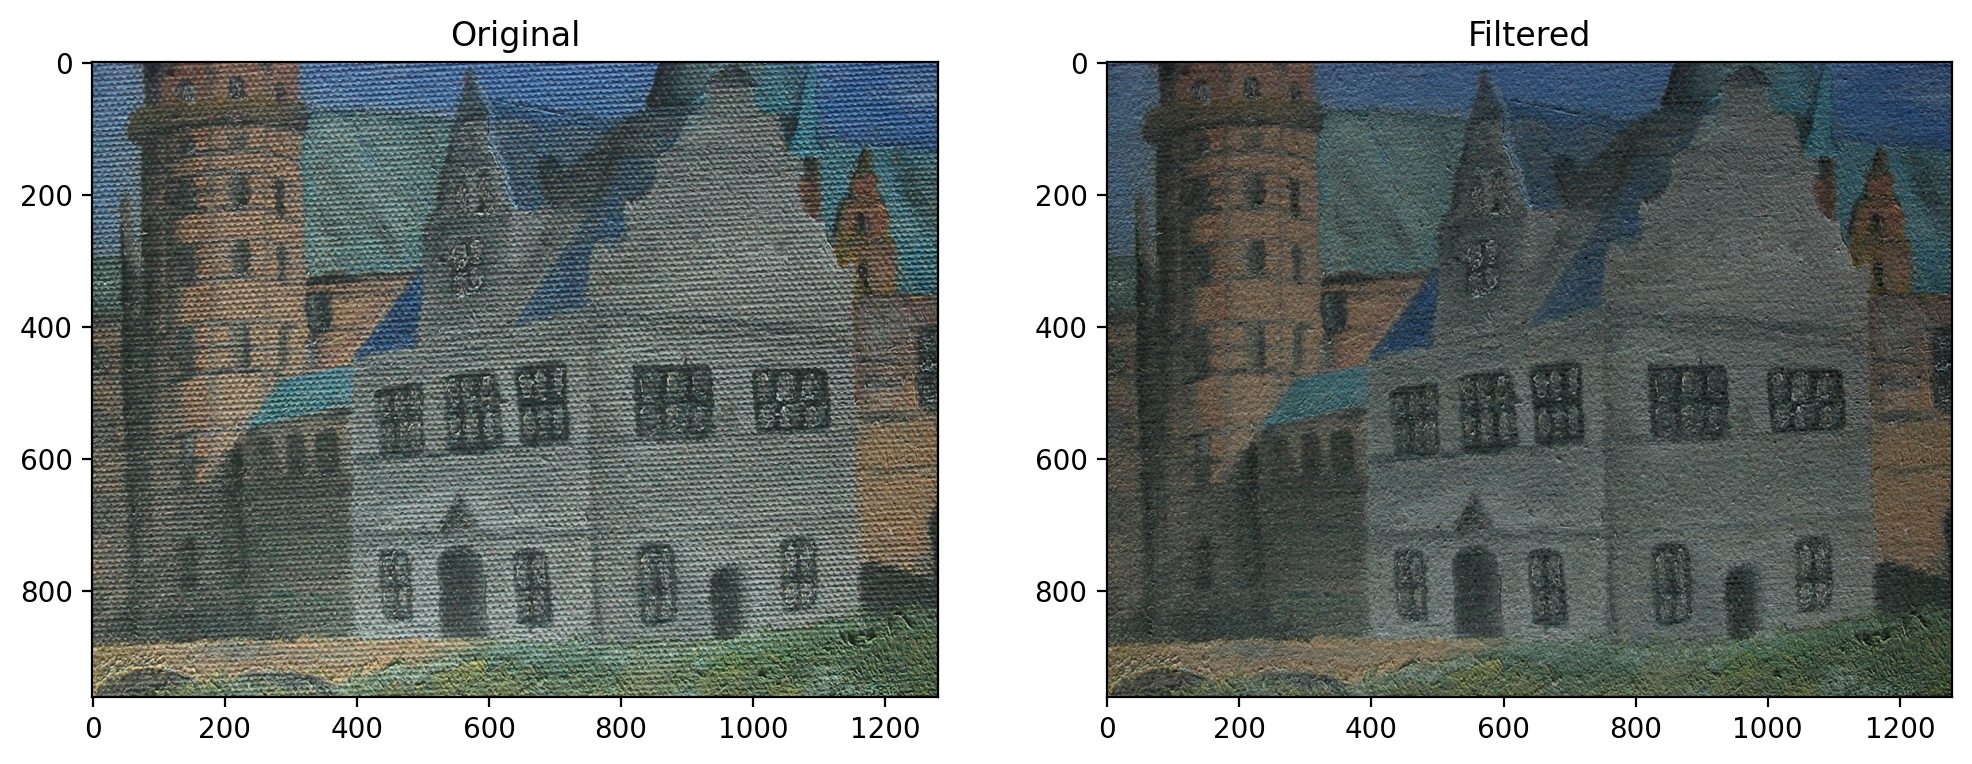

In [ ]:
plt.figure(figsize=[12, 6], dpi=200)

plt.subplot(121)
plt.imshow(pt0)
plt.title('Original')

plt.subplot(122)
plt.imshow(pt_f)
plt.title('Filtered')